Exercise is meant for you to experiment with cython and numba to see how much efficiency can be obtained by using these two tools

In [151]:
import numpy as np
import seaborn as sb
import pandas as pd

In [152]:
class Particle:
  def __init__(self, x, y, ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

In [153]:
def evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def evolve(r_i, ang_speed, timestep, nsteps):
  v_i = np.empty_like(r_i)
  for i in range(nsteps):
    norm_i = np.sqrt((r_i ** 2).sum(axis=1))
    v_i = r_i[:, [1,0]]
    v_i[:, 0] *= -1
    v_i /= norm_i[:, np.newaxis]
    d_i = timestep * ang_speed[:, np.newaxis] * v_i

    r_i += d_i

In [154]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle(coord[i][0], coord[i][1], coord[i][2]))

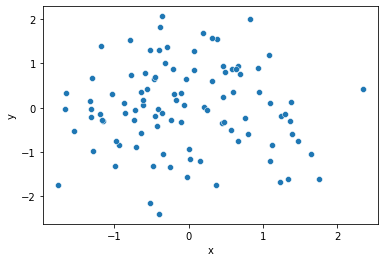

In [155]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [156]:
evolve_wrapper(1, particles)

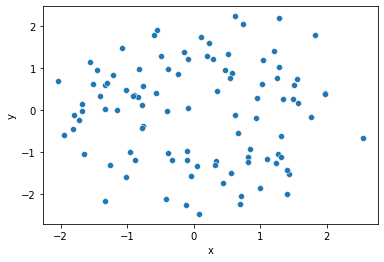

In [157]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [160]:
%timeit evolve_wrapper(1, particles)

265 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Can you rewrite the evolve method to make it faster?

In [161]:
import cython
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [195]:
%%cython

cdef class Particle_c:
  cdef public double x # only viewable to cython
  cdef public double y # only readable, not writable
  cdef readonly double ang_speed # can be read from python file
  def __init__(self, double x, double y, double ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

cpdef void evolve_c(double[:] x_i, double[:] y_i, double[:] ang_speed, int timestep, int nsteps):
  cdef int i, j
  cdef double negvx, vy, negdx, dy, norm

  for i in range(nsteps):
    negvx_i = y_i
    vy_i = x_i
    for j in range(len(x_i)):
      norm = (x_i[j] ** 2 + y_i[j] ** 2) ** 0.5
      negvx /= norm
      vy /= norm
      negdx = timestep * ang_speed[j] * negvx
      dy = timestep * ang_speed[j] * vy
      x_i[j] = x_i[j] - negdx
      y_i[j] = y_i[j] + dy

import numpy as np
cpdef void evolve_wrapper_c(double dt, list particles):
  cdef int timestep = 1
  cdef int j
  cdef int nsteps = int(dt/timestep)
  cdef double[:] x_i = np.zeros(len(particles))
  cdef double[:] y_i = np.zeros(len(particles))
  cdef double[:] ang_speed = np.zeros(len(particles))
  for j in range(len(particles)):
    x_i[j] = particles[j].x
    y_i[j] = particles[j].y
    ang_speed[j] = particles[j].ang_speed
  evolve_c(x_i, y_i, ang_speed, timestep, nsteps)

In [196]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle_c(coord[i][0], coord[i][1], coord[i][2]))

In [197]:
%timeit evolve_wrapper_c(1, particles)

43.9 µs ± 401 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
